# Deep Learning
# DL04 Entrenamiento Pytorch


## <font color='blue'>Entrenando las redes neuronales</font>

#### No ejecute el notebook completo. También tenga cuidado con el numero de epochs. El proceso puede ser lento.

### Función Loss o de perdida.

La red que construimos en la parte 2, no sabe nada sobre nuestros dígitos escritos a mano. Sin embargo para que Las redes neuronales con activaciones no lineales funcionan como aproximadores de funciones universales, se debe enseñar la forma de la función. Que ocurre con las imagenes?, como le asignamos una función de aproximación o de aprendizje?. Las imágenes de dígitos escritos a mano la podemos asociar a probabilidades de clase. El poder de las redes neuronales es que podemos entrenarlas para aproximar esta función, y básicamente cualquier función con suficientes datos y tiempo de cálculo.

![Log](https://drive.google.com/uc?export=view&id=1d7hNBU9q8x7D8XQPqDg1xqXuxrC9hyjS)


Al principio, la red es ingenua, no conoce la función que asigna las entradas a las salidas. Entrenamos la red mostrándole ejemplos de datos reales, luego ajustamos los parámetros de la red de modo que se aproxime a esta función.

Para encontrar estos parámetros, necesitamos saber qué tan mal está prediciendo la red los resultados reales. Para esto calculamos una **función de pérdida (loss function)** (también llamada __función de costo__), una medida de nuestro error de predicción. Dependiendo de qué función decosto usemos dependerá, a posteriori, el proceso de __back propagation__. Por ejemplo, la pérdida cuadrática media a menudo se usa en problemas de regresión y clasificación binaria.
<br>
$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$
<br>
Donde $n$ es el numero de ejemplo de entrenamiento, $y_i$ son los valores reales o etiquetas, y $\hat{y}_i$ son los valores predecidos.

### Optimización de los pesos




Al minimizar esta pérdida con respecto a los parámetros de la red, podemos encontrar configuraciones donde la pérdida es mínima y la red puede predecir las etiquetas correctas con alta precisión. Encontramos este mínimo usando un proceso llamado **descenso de gradiente**. El gradiente es la pendiente de la función de pérdida y apunta en la dirección del cambio más rápido. Para llegar al mínimo en la menor cantidad de tiempo, entonces queremos seguir el gradiente (hacia abajo). Puedes pensar en esto como descender una montaña siguiendo la pendiente más empinada hasta la base.


![Log](https://drive.google.com/uc?export=view&id=1-kPnRcfH8bhPH1vzQsWrRGC_0Nptc7jR)


### Backpropagation

Para redes de una sola capa, el descenso de gradiente es fácil de implementar. Sin embargo, es más complicado para redes neuronales multicapa más profundas como la que hemos construido. Lo suficientemente complicado como para que pasaron unos 30 años antes de que los investigadores descubrieran cómo entrenar redes multicapa.

El entrenamiento de redes multicapa se realiza a través de **backpropagation**, que en realidad es solo una aplicación de la regla de la cadena del cálculo. Es más fácil de entender si convertimos una red de dos capas en una representación gráfica.


![Log](https://drive.google.com/uc?export=view&id=1I7-fkRYztOZDU1P1JTo17DCFMc6O8tIO)


En el paso directo a través de la red, nuestros datos y operaciones van de abajo hacia arriba aquí. Pasamos la entrada $x$ a través de una transformación lineal $L_1$ con pesos  $W_1$ y sesgos $b_1$. La salida luego pasa por la operación sigmoidea $S$ y otra transformación lineal $L_2$. Finalmente calculamos la pérdida $ \ell $. Usamos la pérdida como una medida de cuán malas son las predicciones de la red. El objetivo entonces es ajustar los pesos y sesgos para minimizar la pérdida.

Para entrenar los pesos con descenso de gradiente, propagamos el gradiente de la pérdida hacia atrás a través de la red. Cada operación tiene algún gradiente entre las entradas y salidas. A medida que enviamos los gradientes hacia atrás, multiplicamos el gradiente entrante con el gradiente para la operación. Matemáticamente, esto es solo calcular el gradiente de la pérdida con respecto a los pesos usando la regla de la cadena.


$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$


Actualizamos nuestros pesos usando este gradiente con cierta tasa de aprendizaje $ \ alpha $.

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

La tasa de aprendizaje $ \ alpha $ se establece de manera que los pasos de actualización de peso sean lo suficientemente pequeños como para que el método iterativo se establezca en un mínimo.

### Losses in PyTorch

Comencemos por ver cómo calculamos el loss con PyTorch. A través del módulo `nn`, PyTorch proporciona diferentes tipos de loss como por ejemplo ` nn.CrossEntropyLoss`.  En un problema de clasificación como MNIST, estamos utilizando la función softmax para predecir las probabilidades de clase. Con una salida softmax, desea utilizar la entropía cruzada como loss. Para calcular realmente el loss, primero define el criterio y luego pasa la salida de su red y las etiquetas correctas.


Para mas información mirar [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> Este criterio combina `nn.LogSoftmax()` y `nn.NLLLoss()` en una sola clase.
>


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Normalizamos y transformamos.


transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Bajamos y cargamos los datos.
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]


#### Un primer ejemplo utlizando CrossEntropyLoss como loss

In [2]:
# Contruimos una red  feed-forward.
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Definiendo el loss. Recordar que esta integrado con el softmax en el caso del CrossEntropyLoss.
criterion = nn.CrossEntropyLoss()

# Obtengamos la data.
images, labels = next(iter(trainloader))
# Convirtiendo a vector.
images = images.view(images.shape[0], -1)

# Forward pass, obteniendo el logits.
logits = model(images)
# Calculando el loss
loss = criterion(logits, labels)

print(loss)

tensor(2.3060, grad_fn=<NllLossBackward0>)


#### Un segundoejemplo utlizando NLLLoss como loss

https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

In [3]:
# Contruimos una red  feed-forward.
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Definiendo el loss.
criterion = nn.NLLLoss()

# Obtengamos la data.
images, labels = next(iter(trainloader))
# Convirtiendo a vector.
images = images.view(images.shape[0], -1)

# Forward pass, obteniendo las probabilidades.
logps = model(images)
# Calculando el loss
loss = criterion(logps, labels)

print(loss)

tensor(2.3011, grad_fn=<NllLossBackward0>)


### Autograd


Ahora que sabemos cómo calcular un loss, ¿cómo lo usamos para realizar la propagación hacia atrás? Torch proporciona un módulo, 'autograd', para calcular automáticamente los gradientes de los tensores. Podemos usarlo para calcular los gradientes de todos nuestros parámetros con respecto a la pérdida. Autograd funciona haciendo un seguimiento de las operaciones realizadas en los tensores, luego retrocediendo a través de esas operaciones, calculando los gradientes en el camino. Para asegurarse de que PyTorch realiza un seguimiento de las operaciones en un tensor y calcula los gradientes, debe establecer `require_grad = True` en un tensor. Puede hacer esto en la creación con la palabra clave `require_grad`, o en cualquier momento con `x.requires_grad_ (True)`.

Puede desactivar gradientes para un bloque de código con el `torch.no_grad()`:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```
Tambien podemos apagar el calculo de gradientes con `torch.set_grad_enabled(True|False)`.



Los gradientes son caculados respecto de alguna variable `z` con `z.backward()`.

#### Un ejemplo concreto con calculos de gradientes.

In [4]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 0.3553, -0.8962],
        [ 0.0301, -0.4731]], requires_grad=True)


In [5]:
y = x**2
print(y)

tensor([[0.1263, 0.8032],
        [0.0009, 0.2238]], grad_fn=<PowBackward0>)


A continuación podemos ver la operación que creó `y`, una operación de potencia`PowBackward0`.

In [6]:
## grad_fn muestra la funcion generada por esta variable.
print(y.grad_fn)

El módulo de autograd realiza un seguimiento de estas operaciones y sabe cómo calcular el gradiente de cada una. De esta manera, puede calcular los gradientes para una cadena de operaciones, con respecto a cualquier tensor. Reduzcamos el tensor `y` a un valor escalar, la media.

In [7]:
z = y.mean()
print(z)

tensor(0.2885, grad_fn=<MeanBackward0>)


Puede verificar los gradientes para `x` e` y` pero actualmente están vacíos.

In [8]:
print(x.grad)

None


Para calcular los gradientes, debe ejecutar el método `.backward` en una Variable,` z` por ejemplo. Esto calculará el gradiente para `z` con respecto a` x`

$$
\frac{\partial z}{\partial x_j} = \frac{\partial}{\partial x_j}\left[\frac{1}{4}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [9]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.1777, -0.4481],
        [ 0.0150, -0.2365]])
tensor([[ 0.1777, -0.4481],
        [ 0.0150, -0.2365]], grad_fn=<DivBackward0>)


### Loss and Autograd juntos

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

Cuando creamos una red con PyTorch, todos los parámetros se inicializan con `require_grad = True`. Esto significa que cuando calculamos el loss y llamamos `loss.backward ()`, se calculan los gradientes para los parámetros. Estos gradientes se utilizan para actualizar los pesos con descenso de gradiente.

In [10]:
# Construimos una red  feed-forward.
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.Dropout(0.2),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [11]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [ 0.0101,  0.0101,  0.0101,  ...,  0.0101,  0.0101,  0.0101],
        ...,
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [ 0.0047,  0.0047,  0.0047,  ...,  0.0047,  0.0047,  0.0047],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002]])


### Entrenemos la red.

Hay una última pieza que necesitamos para comenzar a entrenar, un optimizador que usaremos para actualizar los pesos con los gradientes. Los obtenemos del paquete [`optim` package](https://pytorch.org/docs/stable/optim.html). Por ejemplo, podemos usar el descenso de gradiente estocástico con `optim.SGD`. Se puede ver cómo definir un optimizador a continuación.

In [12]:
from torch import optim

# Los optimizadores requieren los parámetros para optimizar y una tasa de aprendizaje
# SGD Stochactic Gradien Descent - Utiliza batchs de datos para entrenar en cada epoch
optimizer = optim.SGD(model.parameters(), lr=0.01)

## <font color='green'>**Actividad 1**</font>

Ahora sabemos cómo usar todas las partes individuales, así que es momento de ver cómo funcionan juntas.  El proceso general con PyTorch:

* Hacer un _forwar_d a través de la red
* Use la salida de red para calcular el _loss_
* Realice un paso hacia atrás a través de la red con `loss.backward ()` para calcular los gradientes
* Da un paso con el optimizador para actualizar los pesos

### Entrenamiento.

Ahora pondremos este algoritmo en un ciclo para que podamos ver todas las imágenes. Alguna nomenclatura, una pasada a través de todo el conjunto de datos se llama **epoch**. Así que aquí vamos a recorrer el `trainloader` para obtener nuestros lotes de entrenamiento. Para cada lote, haremos un pase de entrenamiento donde calcularemos la pérdida, haremos un pase hacia atrás y actualizaremos los pesos.

### Tenga cuidado con el numero de epochs. El proceso puede ser lento.

**Ayuda**

1. Defina una red por ejemplo:



```
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
```
2. Defina el loss
3. Defina el optimizador
4. Itere respecto de las epochs:



```
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
      # Genere un vector de 784 caracteristicas.
      images = images.view(images.shape[0], -1)
      #Realice el forward
      # Calcule el loss.
      # Realice el backward()
      # Optimice
      # Acumule el loss.
```




Ahora nuestra red puede predecir de mejor precisión los dígitos en nuestras imágenes.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Definir la red con 2 capas ocultas
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)  # se usa con NLLLoss
)

# 2. Definir la función de pérdida
criterion = nn.NLLLoss()

# 3. Definir el optimizador
optimizer = optim.SGD(model.parameters(), lr=0.003)

# 4. Entrenamiento
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Aplanar las imágenes de (batch_size, 1, 28, 28) → (batch_size, 784)
        images = images.view(images.shape[0], -1)

        # Paso hacia adelante
        output = model(images)

        # Calcular la pérdida
        loss = criterion(output, labels)

        # Limpiar los gradientes anteriores
        optimizer.zero_grad()

        # Paso hacia atrás
        loss.backward()

        # Actualizar pesos
        optimizer.step()

        # Acumular la pérdida
        running_loss += loss.item()

    print(f"Epoch {e+1} - Loss: {running_loss:.4f}")

Epoch 1 - Loss: 1524.1199
Epoch 2 - Loss: 780.0229
Epoch 3 - Loss: 630.7492
Epoch 4 - Loss: 569.2751
Epoch 5 - Loss: 529.2040


<font color='green'>**Fin Actividad 1**</font>

**Clasificación de Ropa**

En este ejercicio, trabajarán con el conjunto de datos FashionMNIST, que consiste en imágenes de prendas de vestir en 10 categorías: camisetas, pantalones, suéteres, vestidos, abrigos, sandalias, camisas, zapatillas, bolsas y botas. Cada imagen tiene una resolución de 28x28 píxeles y está etiquetada con una de las 10 categorías.

Objetivo: Construir una red neuronal para clasificar las imágenes de prendas de vestir en las 10 categorías.

Pasos:

Importar las bibliotecas necesarias (torch, torchvision, etc.).

Cargar el conjunto de datos FashionMNIST utilizando torchvision.datasets.FashionMNIST. Dividir los datos en conjuntos de entrenamiento y prueba.

Visualizar algunas imágenes del conjunto de datos.

Definir la arquitectura de la red neuronal. Usar una red neuronal de tres capas, similar a la que se proporcionó en el ejemplo inicial. Utilizar funciones de activación ReLU para las capas ocultas.

Definir la función de pérdida. Usar la función de pérdida de entropía cruzada nn.CrossEntropyLoss().

Realizar un paso forward con un lote de imágenes del conjunto de entrenamiento.

Calcular la función de pérdida con las predicciones obtenidas y las etiquetas reales.

Imprimir el valor de la función de pérdida. Incluya el backpropagation y la optimizacion para que el modelo realice el aprendizaje.

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


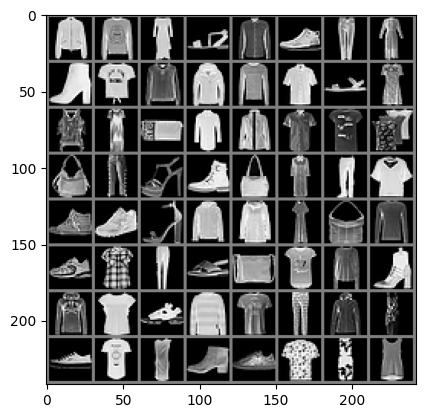

Loss: 2.3294150829315186


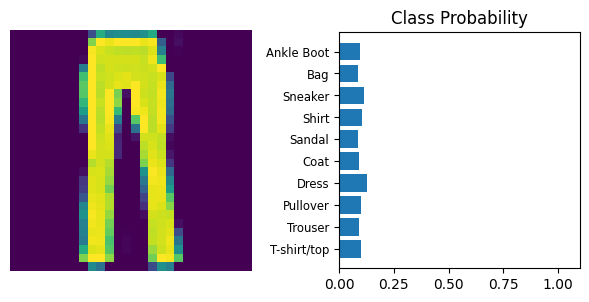

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# Transformación para convertir las imágenes en tensores y normalizarlas
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar el conjunto de datos FashionMNIST
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualizar algunas imágenes del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def view_classify(img, ps, version="Fashion"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                         'Trouser',
                         'Pullover',
                         'Dress',
                         'Coat',
                         'Sandal',
                         'Shirt',
                         'Sneaker',
                         'Bag',
                         'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# Definir la arquitectura de la red neuronal
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instanciar la red neuronal
model = Network()

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Realizar un paso forward con un lote de imágenes
images, labels = next(iter(trainloader))
outputs = model(images)

# Calcular la función de pérdida
loss = criterion(outputs, labels)

# Imprimir el valor de la función de pérdida
print(f"Loss: {loss.item()}")

# Visualizar las predicciones
img_idx = 9
ps = F.softmax(outputs, dim=1)
view_classify(images[img_idx].view(1, 28, 28), ps[img_idx])


[Epoch 1, Batch 100] Loss: 0.918
[Epoch 1, Batch 200] Loss: 0.574
[Epoch 1, Batch 300] Loss: 0.535
[Epoch 1, Batch 400] Loss: 0.504
[Epoch 1, Batch 500] Loss: 0.462
[Epoch 1, Batch 600] Loss: 0.447
[Epoch 1, Batch 700] Loss: 0.431
[Epoch 1, Batch 800] Loss: 0.416
[Epoch 1, Batch 900] Loss: 0.408
[Epoch 2, Batch 100] Loss: 0.385
[Epoch 2, Batch 200] Loss: 0.384
[Epoch 2, Batch 300] Loss: 0.395
[Epoch 2, Batch 400] Loss: 0.393
[Epoch 2, Batch 500] Loss: 0.390
[Epoch 2, Batch 600] Loss: 0.376
[Epoch 2, Batch 700] Loss: 0.369
[Epoch 2, Batch 800] Loss: 0.363
[Epoch 2, Batch 900] Loss: 0.369
[Epoch 3, Batch 100] Loss: 0.329
[Epoch 3, Batch 200] Loss: 0.357
[Epoch 3, Batch 300] Loss: 0.334
[Epoch 3, Batch 400] Loss: 0.340
[Epoch 3, Batch 500] Loss: 0.358
[Epoch 3, Batch 600] Loss: 0.333
[Epoch 3, Batch 700] Loss: 0.325
[Epoch 3, Batch 800] Loss: 0.317
[Epoch 3, Batch 900] Loss: 0.355
[Epoch 4, Batch 100] Loss: 0.314
[Epoch 4, Batch 200] Loss: 0.320
[Epoch 4, Batch 300] Loss: 0.320
[Epoch 4, 

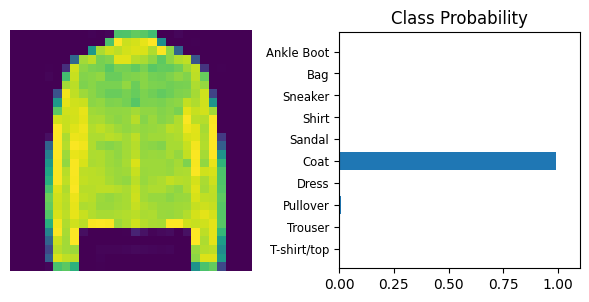

In [14]:
import torch.optim as optim

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar la red neuronal
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        # Inicializar los gradientes a cero
        optimizer.zero_grad()

        # Paso forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Paso backward
        loss.backward()

        # Paso de optimización
        optimizer.step()

        # Imprimir la pérdida
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss/100:.3f}")
            running_loss = 0.0

print("Finished Training")

# Realizar un paso forward con un lote de imágenes
images, labels = next(iter(trainloader))
outputs = model(images)

# Visualizar las predicciones
img_idx = 9
ps = F.softmax(outputs, dim=1)
view_classify(images[img_idx].view(1, 28, 28), ps[img_idx])
